# Estimate $L^2$-norm based Wasserstein distance for Modified IEEE 24-node Model
This version was updated in Sep., 2021.<br/> 

**NOTE: one should modify the data directory before running this script**

## This code aims to 
(1) give detailed information for the data preparation for the modified IEEE 118-node system;<br/>
(2) estimate $L^2$-norm based Wasserstein distance discribing envolutionary changes using long-term forecasts;<br/>

---
## Data source:
(1) Long-term **load forecasts** at ***30*** states in ***India*** (hourly, every five year during 2020-2040)[1], which consider 3 GDP growth scenarios (slow, stable and rapid), 
3 EV charging scenarios (home, work, public charging), 
2 air conditioning scenarios (baseline and energy efficient) <br/>
***The reasons why we select this load data set are that:***
(a) To our knowledge, it is the best in terms of availability and spatial and temproal resolutions;
(b) Apart from factors like economic and technological developments, it also considers the effects of climate change and the corresponding weather variations on air conditioning demands, which is suitable for our work.


(2) Long-term **climate scenarios** and the corresponding **weather forecasts** from World Climate Research Programme (WCRP)-Coupled Model Intercomparison Project Phase 6 (CMIP6) (daily, every year durting 2020-2040)[2].
3 emission scenarios (SSP1-2.6, SSP2-4.5, SSP5-8.5), and 2 globals climate models (GCMs) (i.e.,GFDL, EC-Earth3) are selected. <br/> 
***To make the load data and climate data compatible:***
We selected wind data at seven locations in India from the GCM datasets, given that most of wind resources potentials exist in ***7*** windy states in India [3].



Therefore, a total of ***108*** scenarios are considered in the dataset, including 3 GDP growth scenarios (slow, stable and rapid), 
3 EV charging scenarios (home, work, public charging), 
2 air conditioning scenarios (baseline and energy efficient),
3 emission scenarios (SSP1-2.6, SSP2-4.5, SSP5-8.5), 
and 2 GCMs (GFDL, EC-Earth3).

The data collection is perfomed on MATLAB for convenience, while the relevant files are also attached in the parent folder,  including <br/> 

- get_loadData.m
- getwind_GFDL.m
- getwind_EC.m
- get_Pu_z.m
---

## Data processing for the modified IEEE 118 model####

***To make IEEE 118-node model compatible with the above dataset***:  
The IEEE 118-node model is modified to have ***30*** nodes with base load, ***7*** nodes with wind turbines, and 47 nodes with dispatchable generators and storage devices.
**The raw data for wind power or load can not be used in the IEEE 118 model directly since the amplitudes are not suitable for the transmission network capacity. Thus, we calculate capacity factor instead.** Speficically, the collected load data are normalized as  load capacity factor,  by $P_{\text{load}, i,t}/P_{\text{load}i}^{\max}$. Besides, we select weather data of grid points close to the seven windy states from [2] and calculate the wind power capacity factor by assuming that  parameters of all the wind turbines are the same, as: 
cut-in speed=4m/s, cut-out speed=22.22m/s, rated speed= 10m/s [4]. 

As for the rated capacity for wind power and base load,  we assume that:<br/>
1) Wind power capacity and rate base load capacity at 2020 are two times as much as those in the origical IEEE 118 system, so that the transmisson network can be inadequate;<br/>
2) Wind power capacity increases by two times from 2020 to 2040;<br/>
3) (Rated) base load increases by 3.5 times from 2020 to 2040;<br/>

Thus, the wind power outputs and load data can be calculated which are suitable for the IEEE 118 system.

---
## Data processing for 2-Wasserstein-Type distance estimation
### (The development of 'current' and 'future' states )
For the consistency of data, both the 'current state' and 'future state' are developed from the above data, as
- **The current state:** Data during **2020-2029** are adopted, while **one of the 108 scenarios** are selected, as: stable GDP growth, EV scneario of public charging, baseline AC utilization, SSP1-2.6 and GFDL. 

- **The future state:** Data during **2030-2039** are adopted while all the 108 scenarios are assumed to be possible futures.<br/> 





---
## Input of different methods

- MDRO: future mean, future variance
- DRO+$d$ (i.e., the proposed method)+108 scenarios: future mean, future variance, historical data (to construct empirical distribution), *the $d$ estimated herein*
- DRO without $d$, which assumes the future distribution is the same as the historical one: future mean, future variance (to perform standardization) and historical data (to construct empirical distribution). 




    

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
from zipfile import ZipFile
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'

from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans

import scipy.io as sio
from pyomo.environ import *
import matplotlib.pyplot as plt

from random import random
from scipy.stats import multivariate_normal
from scipy.stats import matrix_normal

import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.linalg as spl
from scipy.optimize import linprog

import ot
from sklearn import preprocessing


In [2]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import gurobipy as gp
from gurobipy import GRB

## Step 1 : Read  standarized data
**NOTE: one should modify the data directory before running this script**

The raw data processing is perfomed on MATLAB for convenience, while the relevant files are also attached in the parent folder,  including <br/> 

- get_loadData.m
- getwind_GFDL.m
- getwind_EC.m
- get_Pu_z.m


In [3]:
MatlabData_dir=os.path.abspath(os.path.join(os.path.curdir,'Data_IEEE118_2'))
Pu_DataSet=sio.loadmat(os.path.join(MatlabData_dir,'Pu_Data_2.mat'))
Pu_Data=Pu_DataSet['Pu_Data']

#### Current_DataSet:  One scenario, aggregating samples over ten years (i.e., 2020-2029) 
The selected scenario for current state is: stable GDP growth, EV scneario of public charging, baseline AC utilization, SSP1-2.6 and GFDL. 

In [4]:
Index_futureS=range(0,108)
Current_years=range(0,10)

Current_DataSet=pd.DataFrame()
for i_year in Current_years:
    
    df_z00=pd.DataFrame(data=Pu_Data[i_year,0]['z00']) 
    Current_DataSet=Current_DataSet.append(df_z00)
    
       

#### Future_DataSet: Scenario 1-108, each scenario aggregates samples over ten years (i.e., 2030-2039)

In [5]:
Future_DataSet2={}
Index_futureS=range(0,108)
Future_years=range(10,20)

for i_s in Index_futureS:
    df_oneS=pd.DataFrame()
    for i_year in Future_years:
        df_z00=pd.DataFrame(data=Pu_Data[i_year,i_s]['z00']) # all the data for future injections
        df_oneS=df_oneS.append(df_z00)
        Future_DataSet2[str(i_s)]=df_oneS

## Step 2: GMM Selection 

## ----Estimate the best number of components, and best covariance type for the GMM model

In [6]:
def get_BIC(X):
    '''Covariance types:
'full' (each component has its own general covariance matrix),
'tied' (all components share the same general covariance matrix),
'diag' (each component has its own diagonal covariance matrix),
'spherical' (each component has its own single variance).'''
    
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 30)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return (bic,best_gmm)

In [7]:
bic,best_gmm=get_BIC(Current_DataSet)

df_bestGMM_current=pd.DataFrame(data=np.zeros((1,2)),columns=['Best number of components','Covariance Type'])
df_bestGMM_current.iloc[0,0]=best_gmm.n_components
df_bestGMM_current.iloc[0,1]=best_gmm.covariance_type

In [8]:
df_bestGMM_future=pd.DataFrame(data=np.zeros((108,2)),columns=['Best number of components','Covariance Type'])
for i in range(0,108):
    X=Future_DataSet2[str(i)]
    
    bic,best_gmm=get_BIC(X)
    
    df_bestGMM_future.iloc[i,0]=best_gmm.n_components
    df_bestGMM_future.iloc[i,1]=best_gmm.covariance_type

In [9]:
df_bestGMM_current
df_bestGMM_future

,Best number of components,Covariance Type
0,28.0,full


,Best number of components,Covariance Type
0,29.0,full
1,29.0,full
2,29.0,full
3,28.0,full
4,25.0,full
...,...,...
103,28.0,full
104,27.0,full
105,29.0,full
106,29.0,full


## Step 3: Fit GMM model to data
 (with optimal components number obtained in Step 2 and covariance type=full)

In [10]:
# function for fitting
def GMM_fit(df_population,n_components):
    # Fit the GMM and save the GMM parameters as distionary and mat. file
    clf = mixture.GaussianMixture(n_components, covariance_type='full')
    clf.fit(df_population)

    GMM={}
    GMM['Pr']=clf.weights_# Pr for each components
    GMM['means']=clf.means_
    GMM['Covariances']=clf.covariances_
    return GMM

In [11]:
def get_wstar(pi0,pi1,M):
    m = ConcreteModel('get_wstar')
    K0,K1=M.shape
    
    #Sets
    m.list_K0=RangeSet(0, K0-1)
    m.list_K1=RangeSet(0, K1-1)    
    
    #vars
    m.w=Var(m.list_K0,m.list_K1,bounds=(0.00001,1))
    
    #cons
    def sum_k1(m,i_k0):
        return sum(m.w[i_k0,i_k1] for i_k1 in m.list_K1)==pi0[i_k0]
    m.con_sumk1=Constraint(m.list_K0, rule=sum_k1)
    
    def sum_k0(m,i_k1):
        return sum(m.w[i_k0,i_k1]  for i_k0 in m.list_K0)==pi0[i_k1]
    m.con_sumk0=Constraint(m.list_K1, rule=sum_k0)    
    
    #obj
    def obj_expr(m):
        return sum(m.w[i_k0,i_k1]*M[i_k0,i_k1] for i_k0 in m.list_K0 for i_k1 in m.list_K1 )
    
    return m

#### The following codes are downloaded from [6]: Wasserstein-type distance betwwen two GMMs

In [12]:
# Wasserstein distance betwwen two Guassians
def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

In [13]:
# Wasserstein-type distance betwwen two GMMs
def GW2(pi0,pi1,mu0,mu1,S0,S1):
    # return the GW2 discrete map and the GW2 distance between two GMMs
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return distGW2

## Step 4: Calculate  2-Wasserstein distances
The 2-Wasserstein distances between current state and future states (108 scenarios) are calculated, as
$d(\mathbb{P}_{\text {current}},\mathbb{P}_{\text {future},s}), (s=1,2,...108)$.
Note that, ten simulations are perfomed while the average distance is reported,  since the results in GMM fitting can be different.

In [14]:
N_s=108
distGMM_set = pd.DataFrame(index=range(0,N_s),
                           columns=['Test_'+str(j+1) for j in range(0,10)])

# historical samples
df_z1=Current_DataSet
n_com1=int(df_bestGMM_current.iloc[0,0])
GMM_z1=GMM_fit(df_z1,n_com1)
pi0=GMM_z1['Pr']
mu0=GMM_z1['means']
S0=GMM_z1['Covariances']

j=0
while j<=9:
    flag=True
    distGMM_0=np.zeros((N_s,1))
    for i_s in range(0,N_s):            
 
            # samples for future states
            df_z2=Future_DataSet2[str(i_s)]    
            n_com2=int(df_bestGMM_future.iloc[i_s,0])
            GMM_z2=GMM_fit(df_z2,n_com2)            
            pi1=GMM_z2['Pr']            
            mu1=GMM_z2['means']            
            S1=GMM_z2['Covariances']      
            

            distGW2=GW2(pi0,pi1,mu0,mu1,S0,S1)
            #print(i_s, distGW2,sqrt(distGW2))
            if distGW2==0:
                print('break this round')
                flag=False
                break
            else:
                distGMM_0[i_s]=sqrt(distGW2)
                
    if not flag: 
        continue # when flag==False, j==j
    else:
        distGMM_set['Test_'+str(j+1)]=distGMM_0
        j+=1
                
                        

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/chenyixuan/minicoda/miniconda3/envs/egrimod-nem-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the ima

## Step 5: Summary and final results

In [15]:
distGMM_set['Average results over 10 tests']=distGMM_set.mean(axis=1)
distGMM_set

,Test_1,Test_2,Test_3,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9,Test_10,Average results over 10 tests
0,4.365862,4.304639,4.372073,4.383832,4.320004,4.338787,4.369666,4.298150,4.317452,4.357214,4.342768
1,4.481432,4.493197,4.432202,4.495189,4.484363,4.517079,4.483624,4.553419,4.541045,4.437130,4.491868
2,4.343144,4.307925,4.413617,4.348042,4.313788,4.257049,4.353870,4.416725,4.391485,4.349782,4.349543
3,4.478680,4.467535,4.364209,4.501551,4.475083,4.450887,4.472322,4.524749,4.411609,4.513964,4.466059
4,4.294419,4.286808,4.272241,4.268015,4.230339,4.258785,4.293735,4.262953,4.237287,4.222002,4.262658
...,...,...,...,...,...,...,...,...,...,...,...
103,4.396568,4.436949,4.427877,4.415085,4.388420,4.446652,4.435173,4.422843,4.401723,4.363849,4.413514
104,4.222780,4.178909,4.269035,4.317241,4.241569,4.325444,4.205372,4.212244,4.255014,4.196907,4.242451
105,4.430250,4.462677,4.482327,4.480169,4.437395,4.385070,4.421792,4.406853,4.483764,4.478017,4.446831
106,4.253511,4.313043,4.323213,4.357898,4.330947,4.266075,4.263100,4.350693,4.274521,4.272621,4.300562


In [16]:
d=distGMM_set['Average results over 10 tests'].mean()
d

4.378072683628053

#### Therefore, we set $d=4.4 $ in our simulation

<Figure size 864x288 with 0 Axes>

Text(0.5, 0, 'No. of scenario')

Text(0, 0.5, 'Estimtated   $d$ ')

(1, 109)

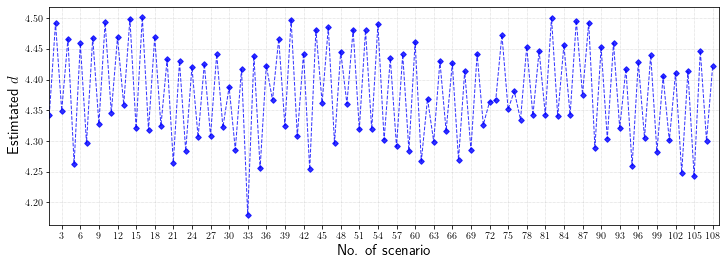

In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator

output_for_mat_dir=os.path.abspath(os.path.join(os.path.curdir, 'output_for_mat'))

rc_fonts = {
    "text.usetex": True,
    'text.latex.preview': True, # Gives correct legend alignment.
    'mathtext.default': 'regular',
    'text.latex.preamble': [r"""\usepackage{bm}"""],
}
mpl.rcParams.update(rc_fonts)
font1= {'family' : 'Times New Roman', 'size':15}


x = np.arange(1,109) 
y = distGMM_set['Average results over 10 tests']

plt.figure(figsize=(12,4))
plt.plot(x,y,'bD--',alpha=0.8, markersize=4, linewidth=1) 
plt.xlabel("No. of scenario",font1) 
plt.ylabel("Estimtated   $d$ ",font1) 

plt.grid(linestyle=':',linewidth=0.5,axis='both')

ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(3))
plt.xlim(1,109)

plt.savefig(os.path.join(output_for_mat_dir,"d_108S.png"),bbox_inches = 'tight')


plt.show()

####  Notes
Please note that the labels of axes in the figures may be changed during writing the paper for better understanding, while the results stay the same. Hope this will not cause confusion.



# References
[1] -Barbar, M., Mallapragada, D.S., Alsup, M. et al. Scenarios of future Indian electricity demand accounting for space cooling and electric vehicle adoption. Sci Data 8, 178 (2021). https://doi.org/10.1038/s41597-021-00951-6

[2] -https://pcmdi.llnl.gov/CMIP6/

[3] -https://mnre.gov.in/wind/current-status/

[4] - H. Yu, C. Y. Chung, K. P. Wong and J. H. Zhang, "A Chance Constrained Transmission Network Expansion Planning Method With Consideration of Load and Wind Farm Uncertainties," in IEEE Transactions on Power Systems, vol. 24, no. 3, pp. 1568-1576, Aug. 2009, doi: 10.1109/TPWRS.2009.2021202.

[5] Gaussian Mixture Model Selection, https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

[6] Delon, Desolneux, A Wasserstein-type distance in the space of Gaussian Mixture Models, 2019,  https://github.com/judelo/gmmot
